# 평당 가격에 대해 통계적 분석

In [36]:
import pandas as pd
import numpy as np

In [41]:
df = pd.read_csv("Data/tmp.csv")
df = df[df["umdNm"] == "연희동"]
print(df)

       Unnamed: 0  dealDate  deposit  monthlyRent  ChangeRate  calcedRent  \
10             10  20110103  34000.0          0.0     7.20000  204.000000   
14             14  20110103  32000.0          0.0     7.20000  192.000000   
36             36  20110105  18000.0          0.0     7.20000  108.000000   
68             68  20110108  26000.0          0.0     7.20000  156.000000   
81             81  20110110  22000.0          0.0     7.20000  132.000000   
...           ...       ...      ...          ...         ...         ...   
34440       34440  20191223   4000.0         50.0     3.71594   62.386467   
34463       34463  20191225  50000.0          0.0     3.71594  154.830833   
34479       34479  20191226  50000.0          0.0     3.71594  154.830833   
34503       34503  20191227   5000.0        110.0     3.71594  125.483083   
34600       34600  20191231  48000.0          0.0     3.71594  148.637600   

       excluUseAr   RPA     aptNm  buildYear contractTerm contractType  flo

In [34]:
mean_rpa = df['RPA'].mean()
std_rpa = df['RPA'].std()

print(f"Mean of RPA: {mean_rpa}")
print(f"Standard Deviation of RPA: {std_rpa}")

Mean of RPA: 2.4547058823529415
Standard Deviation of RPA: 1.1412414723421191


# 다중회귀분석

In [35]:
import pandas as pd
import statsmodels.api as sm

# 결측치 제거
df = df.dropna(subset=['buildYear', 'excluUseAr', 'floor', 'dealDate', 'calcedRent'])

# 독립 변수와 종속 변수 정의
X = df[['buildYear', 'excluUseAr', 'floor', 'dealDate']]  # 독립 변수들
y = df['calcedRent']  # 종속 변수

# 상수항 추가
X = sm.add_constant(X)

# 다중 회귀 모델 적합
model = sm.OLS(y, X).fit()

# 결과 요약 출력
print(model.summary())

# 예측값과 잔차 추가
df['Predicted_RPA'] = model.predict(X)
df['Residuals'] = df['RPA'] - df['Predicted_RPA']

# 결과 확인
print(df[['buildYear', 'deposit', 'monthlyRent', 'excluUseAr', 'RPA', 'Predicted_RPA', 'Residuals']])


                            OLS Regression Results                            
Dep. Variable:             calcedRent   R-squared:                       0.696
Model:                            OLS   Adj. R-squared:                  0.691
Method:                 Least Squares   F-statistic:                     142.9
Date:                Wed, 15 Jan 2025   Prob (F-statistic):           2.23e-63
Time:                        20:43:17   Log-Likelihood:                -1120.0
No. Observations:                 255   AIC:                             2250.
Df Residuals:                     250   BIC:                             2268.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1510.1337   1198.007     -1.261      0.2

# 클러스터링

### 직접 기준 세우기

In [52]:
# 데이터 로드
data = df.copy()
data['buildYear'] = pd.to_numeric(data['buildYear'], errors='coerce')
data['floor'] = pd.to_numeric(data['floor'], errors='coerce')
data['dealYear'] = data['dealDate'].astype(str).str[:4].astype(int)
data['yearsSinceBuilt'] = data['dealYear'] - data['buildYear']

# 결측값 제거
data = data.dropna(subset=['yearsSinceBuilt', 'floor'])

# 군집화 기준 정하기
Built_cut = [-np.inf, 8, 13, np.inf]
Build_label = ['신축', '준신축', '구축']

Floor_cut = [-np.inf, 5, 10, np.inf]
Floor_label = ['저층', '중층', '고층']

# 그룹화
data['Group'] = pd.cut(data['yearsSinceBuilt'], bins=Built_cut, labels=Build_label).astype(str) + '-' + pd.cut(data['floor'], bins=Floor_cut, labels=Floor_label).astype(str)
print(data.groupby('Group')['RPA'].agg(['mean', 'std']).reset_index())

    Group      mean       std
0   구축-고층  1.818675  0.254623
1   구축-저층  1.326015  0.452086
2   구축-중층  1.635144  0.275604
3   신축-고층  2.397766  1.143632
4   신축-저층  2.459924  1.578085
5   신축-중층  2.691656  1.372770
6  준신축-고층  1.892705  0.210592
7  준신축-저층  1.644734  0.340797
8  준신축-중층  1.755944  0.314791


### K-means 클러스터링 사용

In [53]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


그룹별 RPA 평균 및 표준편차:
  Group      mean       std
0   0-0  1.761030  0.270679
1   0-1  1.610726  0.316380
2   0-2  1.841102  0.229258
3   1-0  1.408000  0.132229
4   1-1  0.961078  0.338240
5   2-0  2.503544  1.228407
6   2-1  2.138790  1.271982
7   2-2  1.896916  0.264181


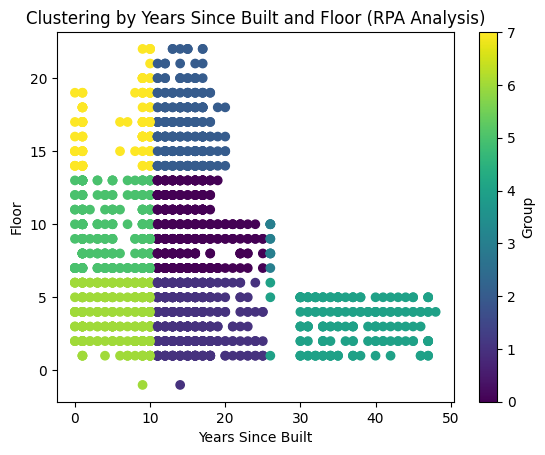

In [55]:
# 데이터 로드
data = df.copy()
data['buildYear'] = pd.to_numeric(data['buildYear'], errors='coerce')
data['floor'] = pd.to_numeric(data['floor'], errors='coerce')
data['dealYear'] = data['dealDate'].astype(str).str[:4].astype(int)
data['yearsSinceBuilt'] = data['dealYear'] - data['buildYear']

# 결측값 제거
data = data.dropna(subset=['yearsSinceBuilt', 'floor'])

# 층수에 대해 K-Means 적용
floor_features = data[['floor']].values
scaler_floor = StandardScaler()
scaled_floor = scaler_floor.fit_transform(floor_features)

kmeans_floor = KMeans(n_clusters=3, random_state=42)
data['floor_cluster'] = kmeans_floor.fit_predict(scaled_floor)

# 준공 연식에 대해 K-Means 적용
years_features = data[['yearsSinceBuilt']].values
scaler_years = StandardScaler()
scaled_years = scaler_years.fit_transform(years_features)

kmeans_years = KMeans(n_clusters=3, random_state=42)
data['years_cluster'] = kmeans_years.fit_predict(scaled_years)

# 그룹화 (연식 클러스터 + 층수 클러스터 조합)
data['Group'] = data['years_cluster'].astype(str) + '-' + data['floor_cluster'].astype(str)

# 그룹별 RPA 평균 및 표준편차 계산
group_stats = data.groupby('Group')['RPA'].agg(['mean', 'std']).reset_index()

# 결과 출력
print("\n그룹별 RPA 평균 및 표준편차:")
print(group_stats)

# 시각화 (층수 vs 준공 연식, 그룹화 표시)
plt.scatter(data['yearsSinceBuilt'], data['floor'], c=data['Group'].astype('category').cat.codes, cmap='viridis')
plt.colorbar(label='Group')
plt.xlabel('Years Since Built')
plt.ylabel('Floor')
plt.title('Clustering by Years Since Built and Floor (RPA Analysis)')
plt.show()